In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
df= pd.read_csv('loan_eligibility_data.csv')

In [3]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64


In [4]:
# Removing missing values using mode for specific columns

columns_to_impute = ['Credit_History', 'Self_Employed', 'Dependents', 'Gender', 'Married']

# Impute missing values using mode for the specified columns
for column in columns_to_impute:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

# Impute missing values using median for specific columns
columns_to_impute = ['LoanAmount', 'Loan_Amount_Term']
for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

In [5]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [6]:
# Check for duplicate rows in the entire DataFrame
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [Loan_ID, Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, Loan_Status]
Index: []


In [7]:
print(df.shape)

(614, 13)


In [8]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


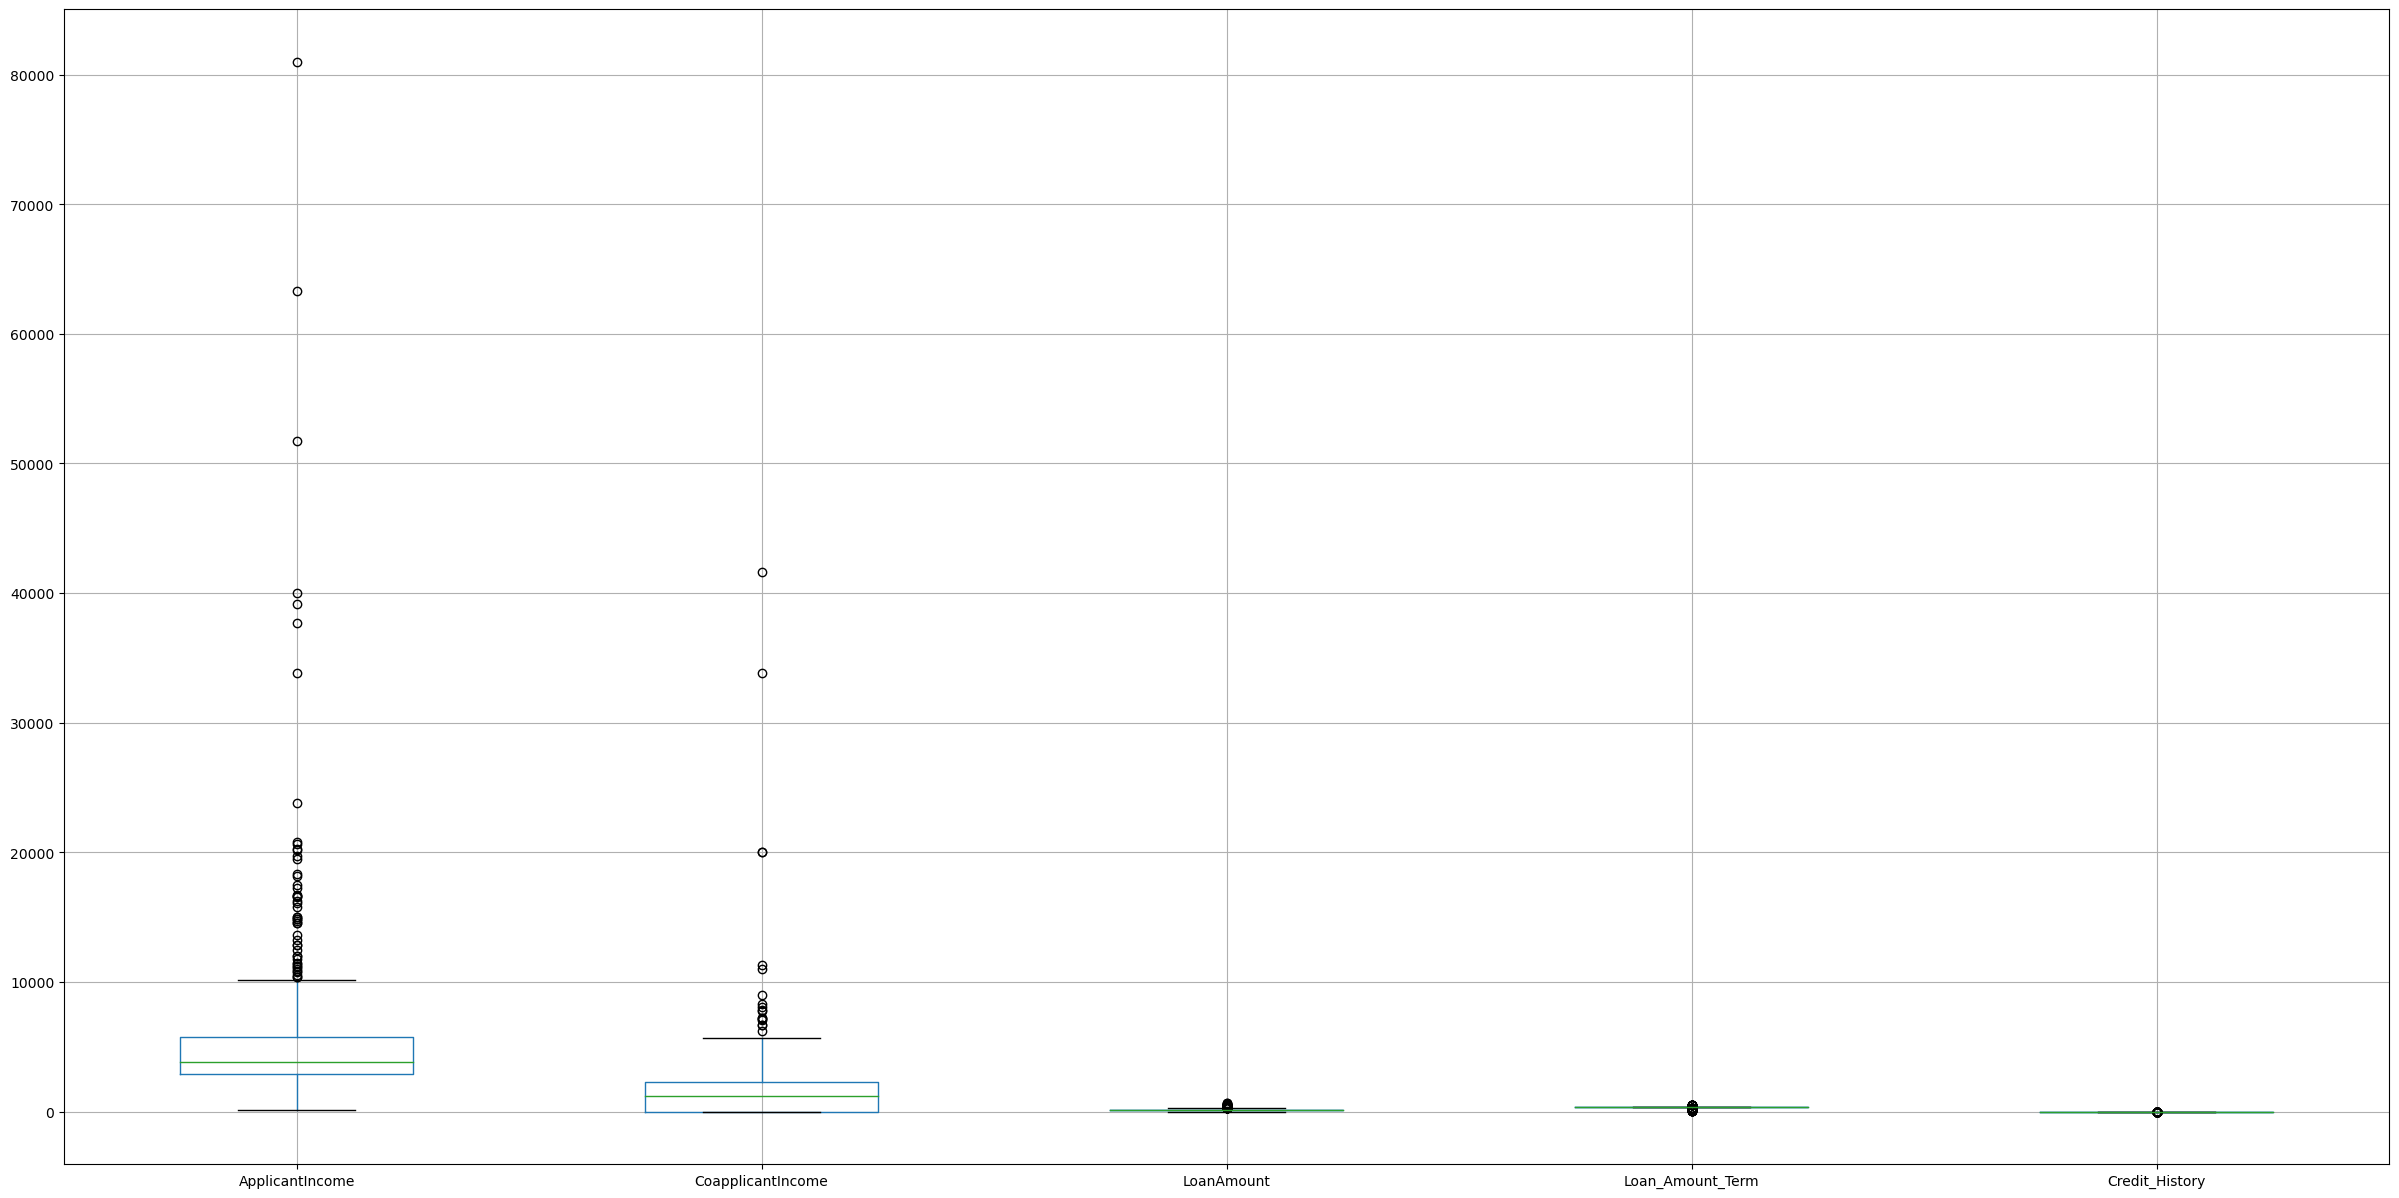

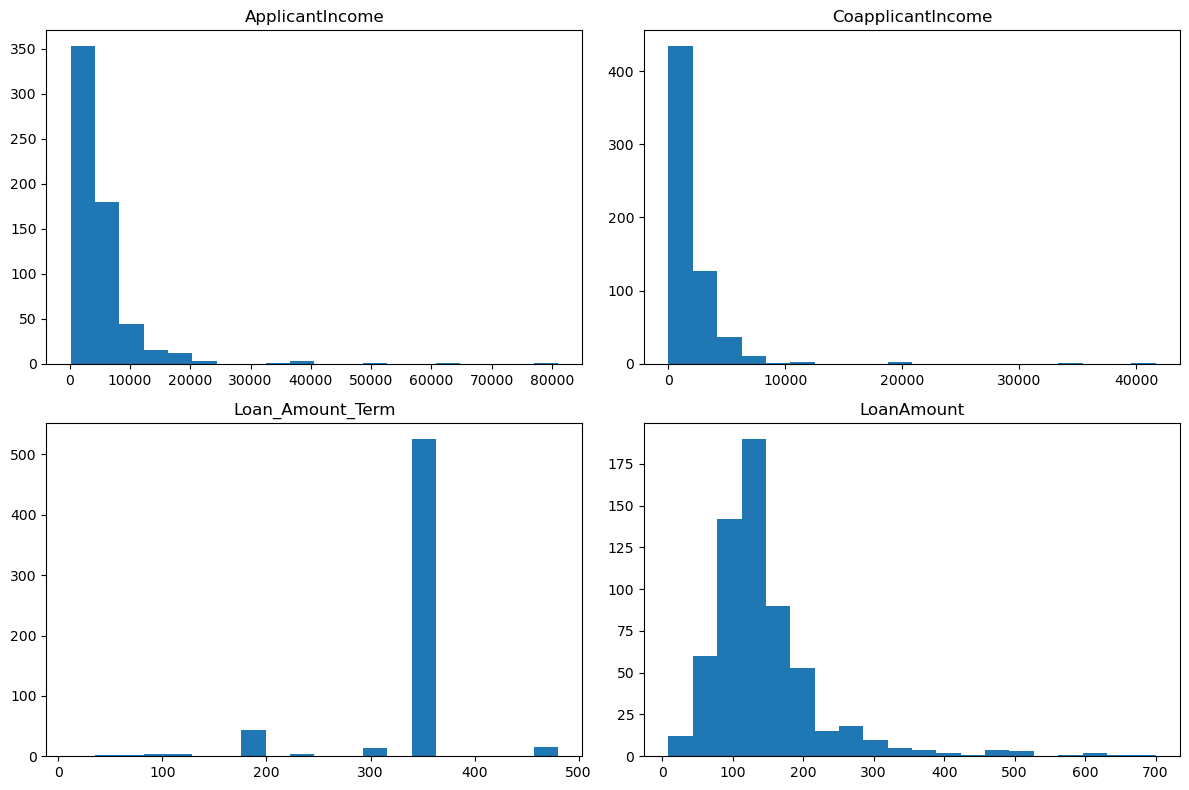

In [9]:
# Plot histograms for each column
df.boxplot(figsize=(30,15))
columns_to_plot = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount']
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.subplot(2, 2, columns_to_plot.index(col) + 1)
    plt.hist(df[col], bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

In [10]:
# handle utliers using iqr method
def check_for_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [11]:
print(df.shape)

(614, 13)


In [12]:
# Data Encoding 
df['Loan_Status'] = df['Loan_Status'].replace('Y',1)
df['Loan_Status'] = df['Loan_Status'].replace('N',0)

df['Married'] = df['Married'].replace('Yes',1)
df['Married'] = df['Married'].replace('No',0)

df['Self_Employed'] = df['Self_Employed'].replace('Yes',1)
df['Self_Employed'] = df['Self_Employed'].replace('No',0)

df['Property_Area']= df['Property_Area'].replace('Urban',0)
df['Property_Area']= df['Property_Area'].replace('Rural',1)
df['Property_Area']= df['Property_Area'].replace('Semiurban',2)

df['Dependents']= df['Dependents'].replace('0',0)
df['Dependents']= df['Dependents'].replace('1',1)
df['Dependents']= df['Dependents'].replace('2',2)
df['Dependents']= df['Dependents'].replace('3+',3)

df['Gender'] = df['Gender'].replace('Male',1)
df['Gender'] = df['Gender'].replace('Female',0)

df['Education'] = df['Education'].replace('Graduate',1)
df['Education'] = df['Education'].replace('Not Graduate',0)

In [13]:
# normalise due to right skewed using Square Root Transformation

columns_to_normalise = ['ApplicantIncome', 'CoapplicantIncome','LoanAmount']
df[columns_to_normalise] = df[columns_to_normalise].apply(np.sqrt)

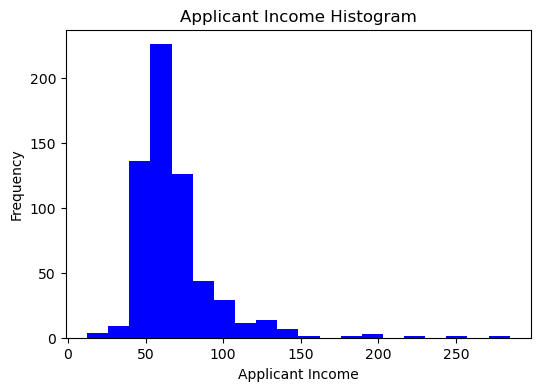

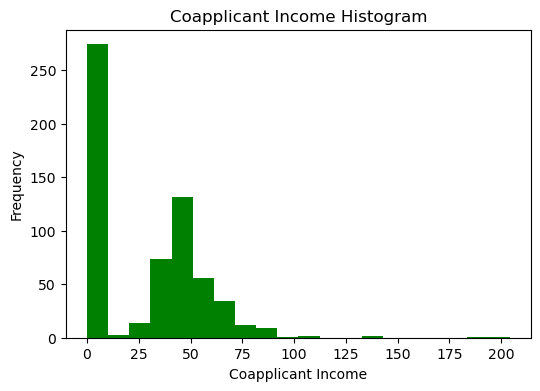

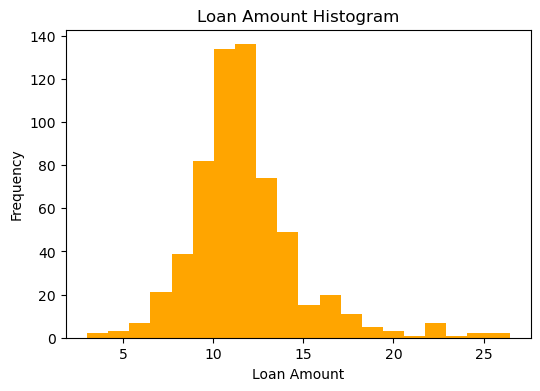

In [14]:
# Plot histogram for 'ApplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['ApplicantIncome'], bins=20, color='blue')
plt.title('Applicant Income Histogram')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'CoapplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['CoapplicantIncome'], bins=20, color='green')
plt.title('Coapplicant Income Histogram')
plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'LoanAmount'
plt.figure(figsize=(6, 4))
plt.hist(df['LoanAmount'], bins=20, color='orange')
plt.title('Loan Amount Histogram')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 62.5+ KB


In [16]:
# add co-applicant and applcant income together feature modification 
df['sum_columns'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Rename the 'sumed columns' column to a new name called Income
df = df.rename(columns={'sum_columns': 'Income'})

In [17]:
# Remove Duplicated and un useful data
df= df.drop('ApplicantIncome',axis=1)
df = df.drop('CoapplicantIncome',axis=1)
df = df.drop('Loan_ID',axis=1)

In [18]:
df1 = df

In [20]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df1.drop(["Loan_Status"], axis=1)
y = df1["Loan_Status"]

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)
feature_importance = rf_classifier.feature_importances_
feature_importance_df1 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print the feature importance by rank
print("Feature Importance:")
print(feature_importance_df1)

Feature Importance:
            Feature  Importance
7    Credit_History    0.266386
9            Income    0.258126
5        LoanAmount    0.230116
2        Dependents    0.055324
8     Property_Area    0.050020
6  Loan_Amount_Term    0.044011
1           Married    0.029491
0            Gender    0.023461
3         Education    0.022687
4     Self_Employed    0.020379


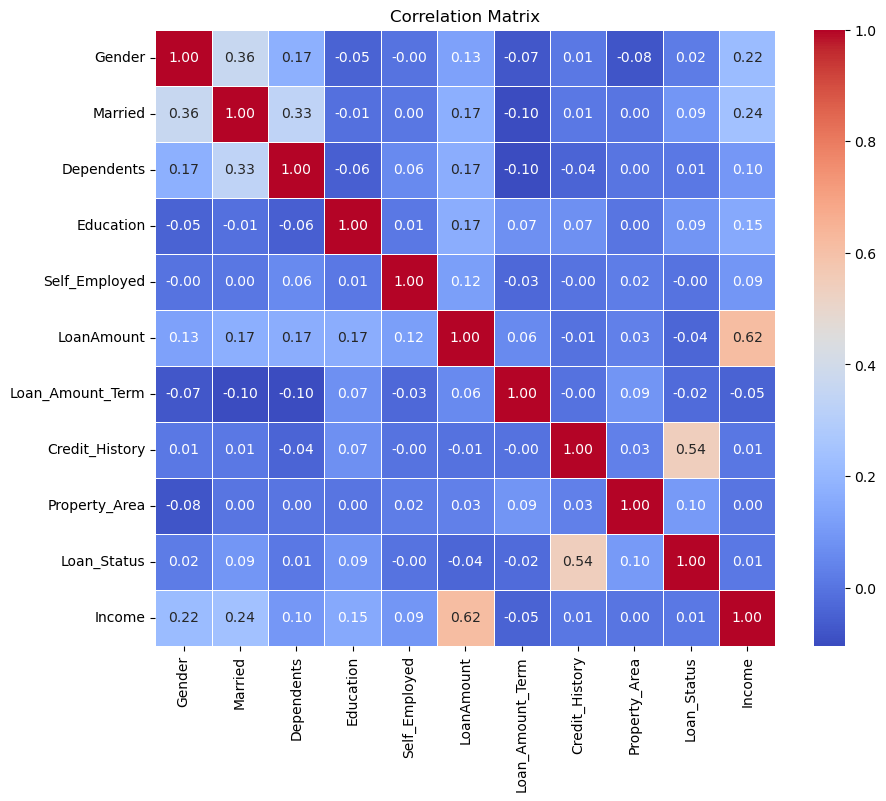

In [22]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

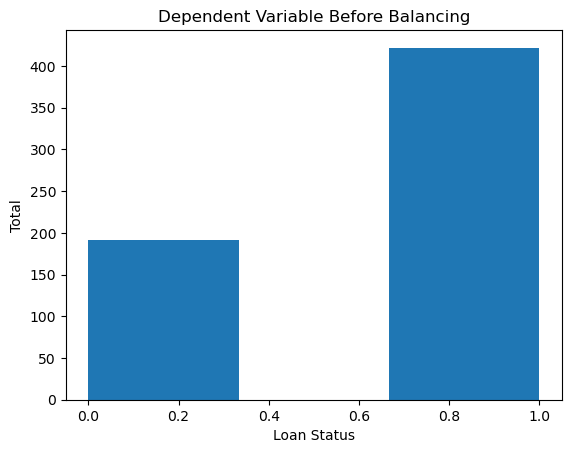

In [23]:
plt.hist(y, bins=3)
plt.title('Dependent Variable Before Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

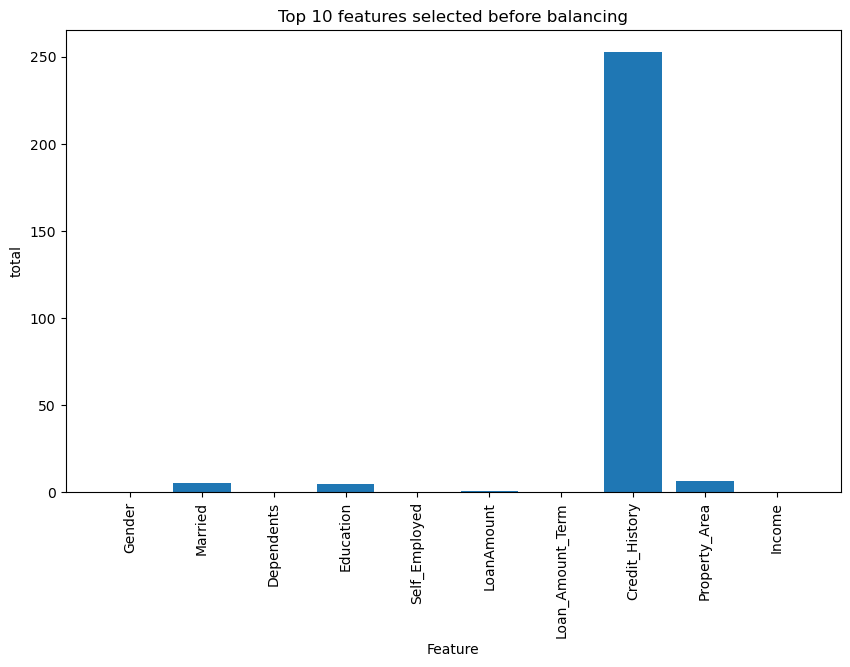

In [24]:
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected before balancing'.format(k))
plt.show()

In [26]:
    # Split the data into train and test sets with a 70/30 split
    X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create a Random Forest classifier
    rf_model_70 = RandomForestClassifier(random_state=42)

    # Train the model on the 70/30 split
    rf_model_70.fit(X_train_70, y_train_70)

    # Predict the target values using the testing data from the 70/30 split
    y_pred_70 = rf_model_70.predict(X_test_70)

    # Evaluate the accuracy of the model on the 70/30 split
    accuracy_70 = accuracy_score(y_test_70, y_pred_70)
    print(f"Accuracy on 70/30 split: {accuracy_70:.2f}")

Accuracy on 70/30 split: 0.79


In [32]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_70)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       32    33
1        5   115


In [33]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_70))

              precision    recall  f1-score   support

           0       0.86      0.49      0.63        65
           1       0.78      0.96      0.86       120

    accuracy                           0.79       185
   macro avg       0.82      0.73      0.74       185
weighted avg       0.81      0.79      0.78       185



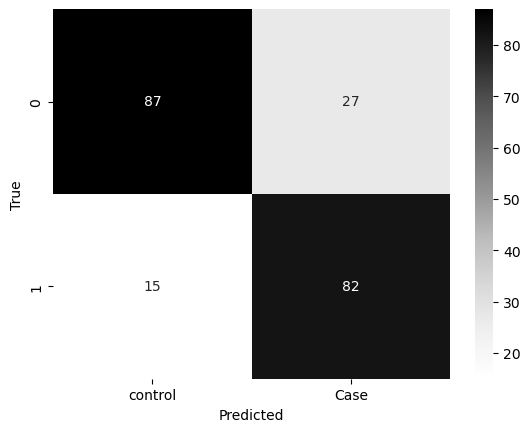

In [86]:
sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.7389743589743589


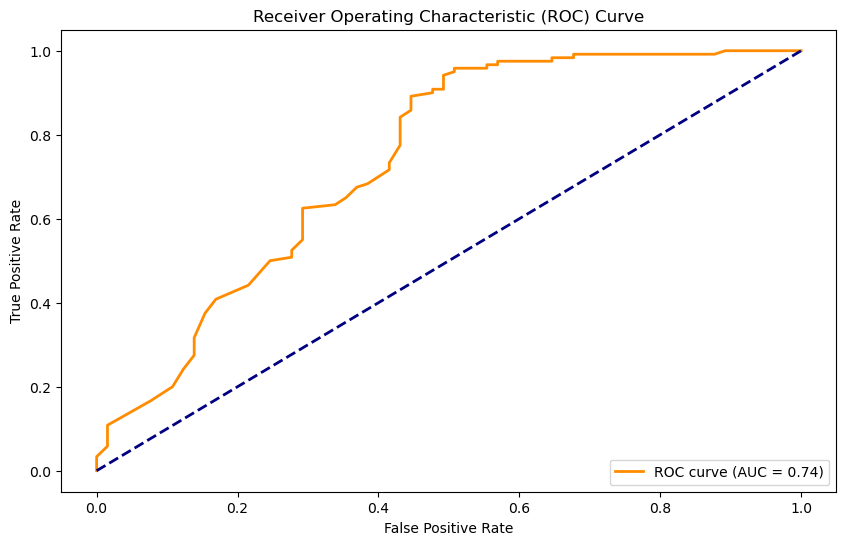

In [42]:
y_prob = rf_model_70.predict_proba(X_test_70)[:, 1]
from sklearn.metrics import roc_curve, roc_auc_score
# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test_70, y_prob)

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:

from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # 75% training and 25% test
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict the target values using the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model using the testing data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.7727272727272727


In [48]:
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       25    29
1        6    94


In [49]:

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.46      0.59        54
           1       0.76      0.94      0.84       100

    accuracy                           0.77       154
   macro avg       0.79      0.70      0.72       154
weighted avg       0.78      0.77      0.75       154



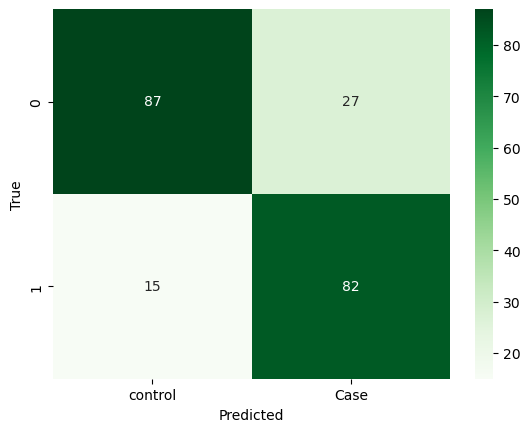

In [87]:
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.7171296296296296


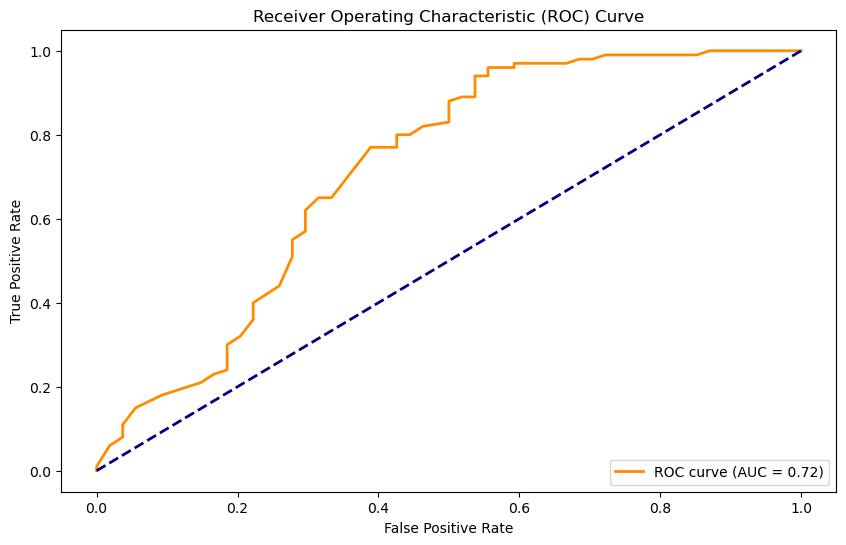

In [51]:

# Predict probabilities for the testing set
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
     

In [52]:

from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)# 80% training and 20% test
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict the target values using the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model using the testing data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.7723577235772358


In [53]:

cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
     

   control  Case
0       19    24
1        4    76


In [54]:

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.44      0.58        43
           1       0.76      0.95      0.84        80

    accuracy                           0.77       123
   macro avg       0.79      0.70      0.71       123
weighted avg       0.78      0.77      0.75       123



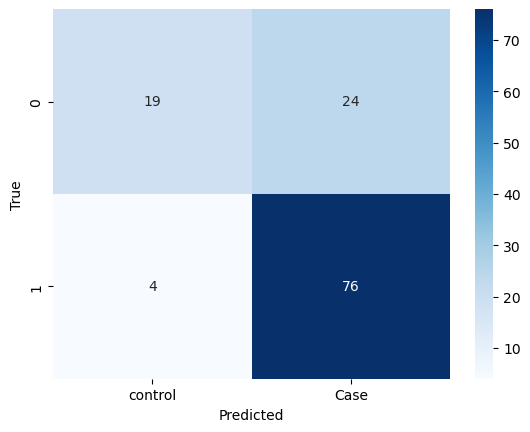

In [55]:
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.6764534883720931


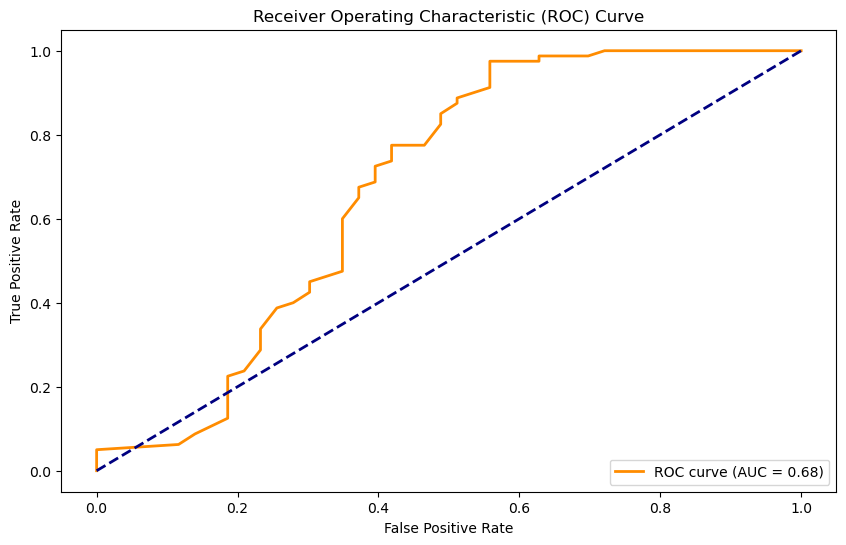

In [56]:

# Predict probabilities for the testing set
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
df2= df1

In [58]:
df2.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income
0,1,0,0,1,0,11.313708,360.0,1.0,0,1,76.478755
1,1,1,1,1,0,11.313708,360.0,1.0,1,0,106.530834
2,1,1,0,1,1,8.124038,360.0,1.0,0,1,54.772256
3,1,1,0,0,0,10.954451,360.0,1.0,0,1,99.382465
4,1,0,0,1,0,11.874342,360.0,1.0,0,1,77.459667


In [60]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df2.drop(["Loan_Status"], axis=1)
y = df2["Loan_Status"]

In [61]:
# Perform oversampling on the data
X, y = SMOTE().fit_resample(X, y)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

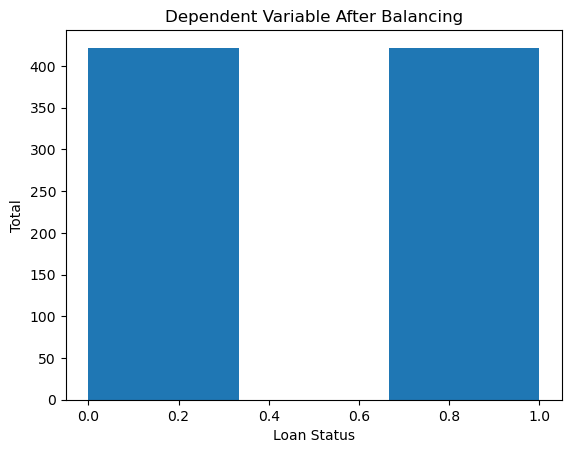

In [62]:
plt.hist(y, bins=3)
plt.title('Dependent Variable After Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

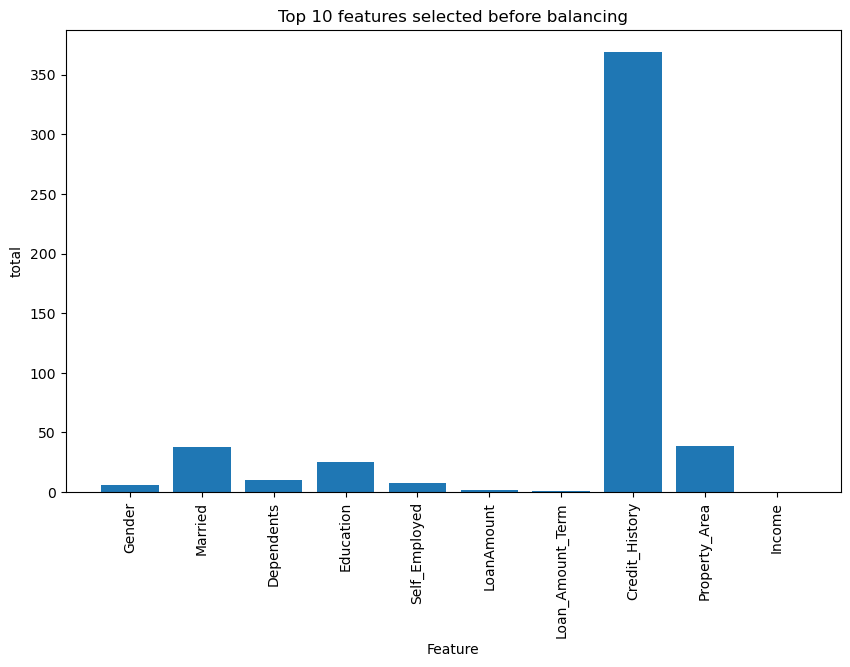

In [63]:
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected before balancing'.format(k))
plt.show()

In [64]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict the target values using the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model using the testing data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.7834645669291339


In [65]:

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       95    41
1       14   104


In [66]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
     

              precision    recall  f1-score   support

           0       0.87      0.70      0.78       136
           1       0.72      0.88      0.79       118

    accuracy                           0.78       254
   macro avg       0.79      0.79      0.78       254
weighted avg       0.80      0.78      0.78       254



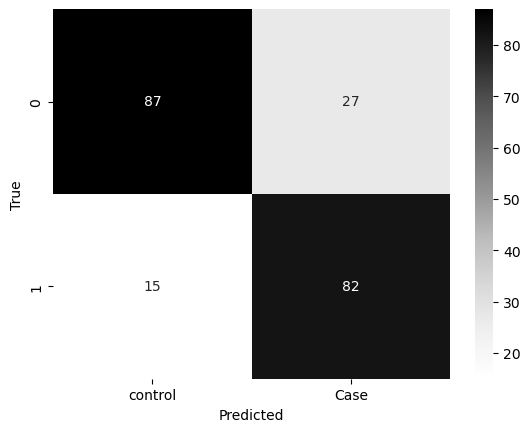

In [84]:

sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.8404474077766699


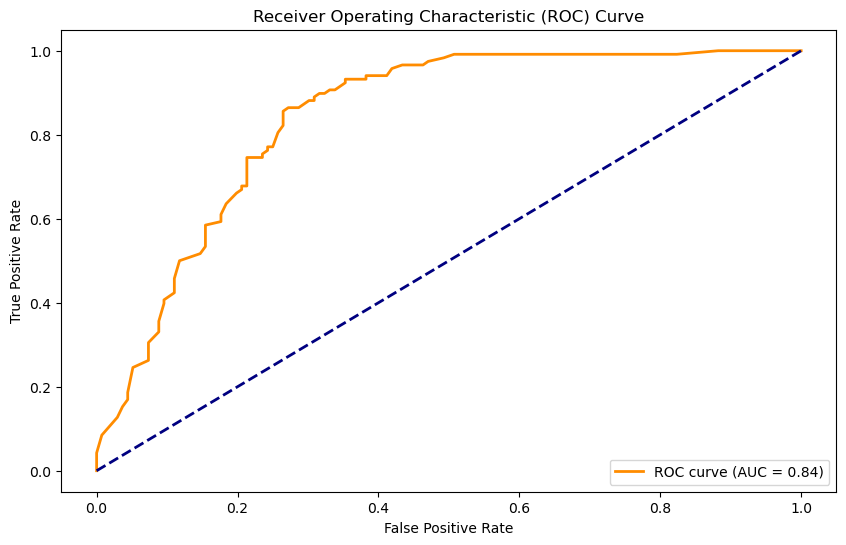

In [68]:
# Predict probabilities for the testing set
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=1)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict the target values using the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model using the testing data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")
     

Accuracy of the model: 0.8009478672985783


In [80]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
     

   control  Case
0       87    27
1       15    82


In [81]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.76      0.81       114
           1       0.75      0.85      0.80        97

    accuracy                           0.80       211
   macro avg       0.80      0.80      0.80       211
weighted avg       0.81      0.80      0.80       211



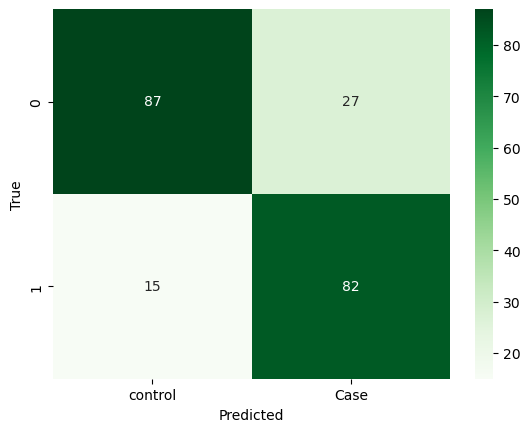

In [85]:

sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.8737565563393018


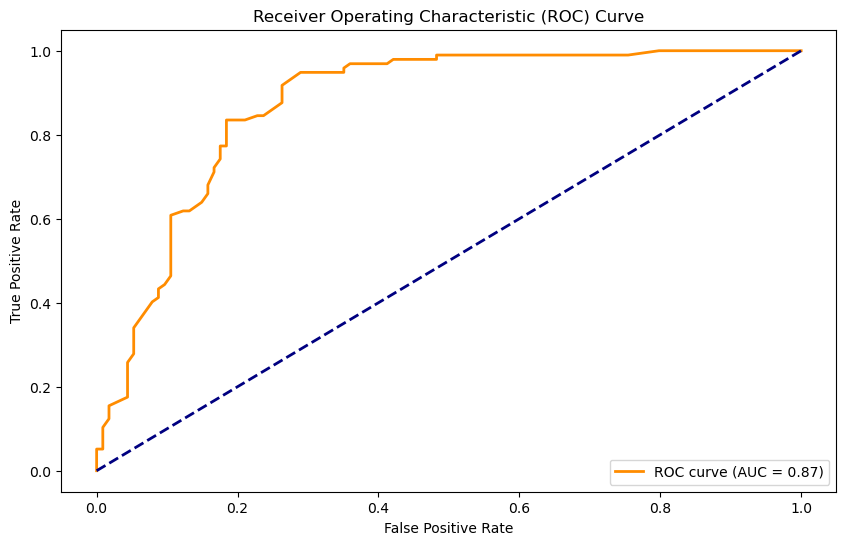

In [83]:
# Predict probabilities for the testing set
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict the target values using the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model using the testing data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.7810650887573964


In [75]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
     

   control  Case
0       68    26
1       11    64


In [76]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.72      0.79        94
           1       0.71      0.85      0.78        75

    accuracy                           0.78       169
   macro avg       0.79      0.79      0.78       169
weighted avg       0.79      0.78      0.78       169



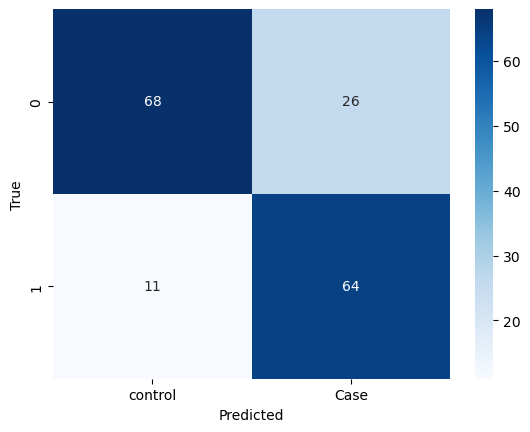

In [77]:
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.8385106382978723


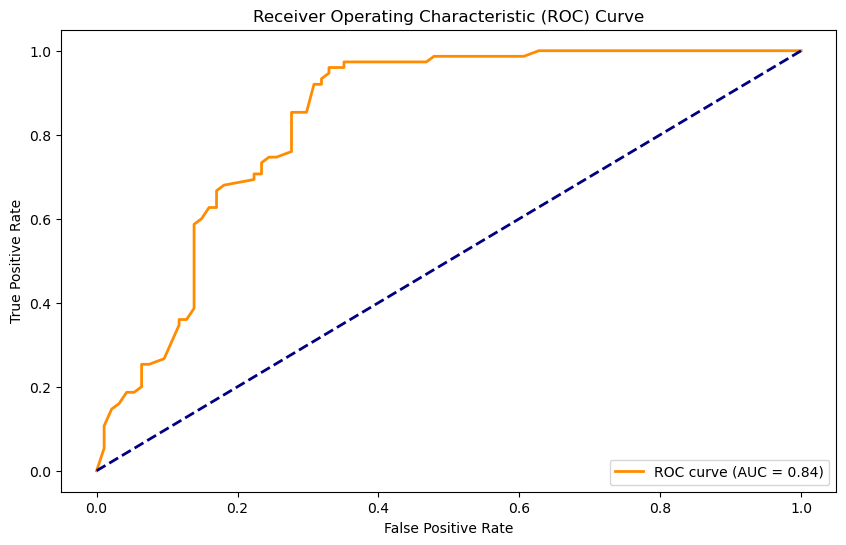

In [78]:
# Predict probabilities for the testing set
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()